# Жанровая классификация

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf

In [184]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Фильтрация метаданных

In [185]:
import glob


DATA_DIR = './data/fma_small/'
METADATA_DIR = './data/fma_metadata/'

mp3_files = glob.glob(DATA_DIR + '*/*.mp3')
mp3_names = list(map(lambda f: np.int64(f.split('/')[-1].split('.')[0]), mp3_files))

raw_tracks = pd.read_csv(METADATA_DIR + 'raw_tracks.csv')
tracks = raw_tracks[raw_tracks['track_id'].isin(mp3_names)]

tracks

,track_id,album_id,album_title,album_url,artist_id,artist_name,artist_url,artist_website,license_image_file,license_image_file_large,...,track_information,track_instrumental,track_interest,track_language_code,track_listens,track_lyricist,track_number,track_publisher,track_title,track_url
0,2,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,4656,en,1293,NaN,3,NaN,Food,http://freemusicarchive.org/music/AWOL/AWOL_-_...
2,5,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1933,en,1151,NaN,6,NaN,This World,http://freemusicarchive.org/music/AWOL/AWOL_-_...
3,10,6.0,Constant Hitmaker,http://freemusicarchive.org/music/Kurt_Vile/Co...,6,Kurt Vile,http://freemusicarchive.org/music/Kurt_Vile/,http://kurtvile.com,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,54881,en,50135,NaN,1,NaN,Freeway,http://freemusicarchive.org/music/Kurt_Vile/Co...
15,140,61.0,The Blind Spot,http://freemusicarchive.org/music/Alec_K_Redfe...,54,Alec K. Redfearn & the Eyesores,http://freemusicarchive.org/music/Alec_K_Redfe...,http://www.aleckredfearn.com,http://i.creativecommons.org/l/by-nc-nd/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1593,en,1299,NaN,2,NaN,Queen Of The Wires,http://freemusicarchive.org/music/Alec_K_Redfe...
16,141,60.0,Every Man For Himself,http://freemusicarchive.org/music/Alec_K_Redfe...,54,Alec K. Redfearn & the Eyesores,http://freemusicarchive.org/music/Alec_K_Redfe...,http://www.aleckredfearn.com,http://i.creativecommons.org/l/by-nc-nd/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,839,en,725,NaN,4,NaN,Ohio,http://freemusicarchive.org/music/Alec_K_Redfe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108843,154308,22780.0,Journey,http://freemusicarchive.org/music/Fleslit/Jour...,23208,Fleslit,http://freemusicarchive.org/music/Fleslit/,https://soundcloud.com/fleslit,http://i.creativecommons.org/l/by/4.0/88x31.png,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,3371,NaN,2705,NaN,17,NaN,MIA,http://freemusicarchive.org/music/Fleslit/Jour...
108844,154309,22780.0,Journey,http://freemusicarchive.org/music/Fleslit/Jour...,23208,Fleslit,http://freemusicarchive.org/music/Fleslit/,https://soundcloud.com/fleslit,http://i.creativecommons.org/l/by/4.0/88x31.png,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,4525,NaN,3589,NaN,18,NaN,A1 Symphony,http://freemusicarchive.org/music/Fleslit/Jour...
108945,154413,22789.0,Live at WFMU for Dark Night of the Soul wtih J...,http://freemusicarchive.org/music/Tasseomancy/...,24252,Tasseomancy,http://freemusicarchive.org/music/Tasseomancy/,https://tasseomancy.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,809,NaN,676,NaN,9,NaN,Do Easy,http://freemusicarchive.org/music/Tasseomancy/...
108946,154414,22789.0,Live at WFMU for Dark Night of the Soul wtih J...,http://freemusicarchive.org/music/Tasseomancy/...,24252,Tasseomancy,http://freemusicarchive.org/music/Tasseomancy/,https://tasseomancy.bandcamp.com/,http://i.creativecommons.org/l/by-nc-nd/4.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,851,NaN,788,NaN,10,NaN,Dead Can Dance (uncensored),http://freemusicarchive.org/music/Tasseomancy/...


## Сбор признаков, полученных с помощью `librosa`

In [186]:
features_df = pd.read_csv(METADATA_DIR + 'features.csv', index_col=0, header=[0, 1, 2])
features_df = features_df[features_df.index.isin(mp3_names)]

features = np.unique(list(map(lambda x: x[0], list(features_df.columns))))

print(f"Features available: {features}")
print(f"Total: {len(features)}")

features_df

Features available: ['chroma_cens' 'chroma_cqt' 'chroma_stft' 'mfcc' 'rmse'
 'spectral_bandwidth' 'spectral_centroid' 'spectral_contrast'
 'spectral_rolloff' 'tonnetz' 'zcr']
Total: 11


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
140           0.533579 -0.623885 -1.086205 -1.081079 -0.765151 -0.072282   
141           0.172898 -0.284804 -1.169662 -1.062855 -0.706868 -0.708281   
...                ...       ...       ...       ...       ...       ...   
154308       -0.677709 -0.830608 -0.686122  0.185158  2.854806 -1.131797   
154309       -0.585059 -0.635075 -0.194742 -0.434809 -1.357310 -0.257745   
154413       -0.214509 -1.130469  0.718534 -0.368448 -0.147830 -0.099409   
154414       -0.487371 -0.923754 -0.283099 -0.435221 -1.137329 -0.798039   
155066        0.044216 -0.300441 -0.217022 -0.356106 -1.085789 -1.185135   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
140        -0.882913 -0.582376 -0.884749 -0.645214  ...  0.157683  0.028070   
141        -0.204884  0.023624 -0.642770 -0.786291  ...  0.145994  0.024342   
...              ...       ...       ...       ...  ...       ...       ...   
154308     -1.161222 -1.110237 -0.818111 -1.388484  ...  0.117287  0.021906   
154309     -0.639082 -0.572640 -1.225242  5.548715  ...  0.180397  0.029303   
154413     -1.325709 -0.105248 -1.363881  1.229534  ...  0.156587  0.036926   
154414     -0.258168  1.004049 -0.499121  0.746973  ...  0.181294  0.026723   
155066     -0.655948 -1.517006 -0.490595 -1.267883  ...  0.189816  0.029439   

feature                      zcr                                          \
statistics              kurtosis       max      mean    median       min   
number            06          01        01        01        01        01   
track_id                                                                   
2           0.012111    5.758890  0.459473  0.085629  0.071289  0.000000   
5           0.014759    6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921   21.434212  0.452148  0.077515  0.071777  0.000000   
140         0.025946   11.052547  0.379395  0.052379  0.036621  0.001953   
141         0.032111   32.994659  0.415527  0.040267  0.034668  0.002930   
...              ...         ...       ...       ...       ...       ...   
154308      0.021999   53.807804  0.769043  0.042997  0.022949  0.001953   
154309      0.023771   12.597441  0.768555  0.082979  0.037109  0.008789   
154413      0.038113   25.368595  0.323242  0.024532  0.018066  0.000977   
154414      0.030980   21.276468  0.511230  0.046116  0.033691  0.003418   
155066      0.025806  116.044044  0.554199  0.016058  0.009766  0.000000   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
5           2.193303  0.044861  
10          3.542325  0.040800  
140         3.143968  0.057712  
141         4.204097  0.028665  
...              ...       ...  
154308      6.928385  0.084298  
154309      3.441251  0.129480  
154413      3.736646  0.023821  
154414      3.997052  0.045733  
155066      9.688635  0.030787  

[8000 rows x 518 columns]

## Отбор признаков

Рассмотрим всю имеющуюся информацию о треках

In [187]:
tracks.columns

Index(['track_id', 'album_id', 'album_title', 'album_url', 'artist_id',
       'artist_name', 'artist_url', 'artist_website', 'license_image_file',
       'license_image_file_large', 'license_parent_id', 'license_title',
       'license_url', 'tags', 'track_bit_rate', 'track_comments',
       'track_composer', 'track_copyright_c', 'track_copyright_p',
       'track_date_created', 'track_date_recorded', 'track_disc_number',
       'track_duration', 'track_explicit', 'track_explicit_notes',
       'track_favorites', 'track_file', 'track_genres', 'track_image_file',
       'track_information', 'track_instrumental', 'track_interest',
       'track_language_code', 'track_listens', 'track_lyricist',
       'track_number', 'track_publisher', 'track_title', 'track_url'],
      dtype='object')

Оценим число непустых значений тегов

In [188]:
tracks['tags'].map(lambda x: None if x == '[]' else x).notnull().value_counts()

False    6639
True     1361
Name: tags, dtype: int64

Подсчитаем число уникальных тегов

In [189]:
from functools import reduce


unique_tags = reduce(lambda tags, l: tags.union(eval(l)), tracks['tags'], set())  
print(len(unique_tags))

1191


Оставим предположительно полезную информацию из набора данных. Убедимся
в её необходимости позже.

In [190]:
to_keep = [
  'track_id', "album_id", "artist_id", "track_duration", 
  "track_genres", "track_instrumental", "track_interest", "track_listens",
]

filtered_tracks = tracks[to_keep]
filtered_tracks

,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,02:48,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,03:26,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,02:41,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,04:13,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,03:02,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,03:14,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,02:42,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,05:49,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,05:46,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Преобразуем время в секунды

In [191]:
def duration_to_int(t):
  splitted = t.split(":")
  
  return int(splitted[0]) * 60 + int(splitted[1])

filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
filtered_tracks

/tmp/ipykernel_20101/3619144929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)
/tmp/ipykernel_20101/3619144929.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  filtered_tracks.loc[:,'track_duration'] = filtered_tracks.track_duration.apply(duration_to_int)


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4656,1293
2,5,1.0,1,206,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,1933,1151
3,10,6.0,6,161,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",0,54881,50135
15,140,61.0,54,253,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,1593,1299
16,141,60.0,54,182,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,3371,2705
108844,154309,22780.0,23208,162,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",0,4525,3589
108945,154413,22789.0,24252,349,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,809,676
108946,154414,22789.0,24252,346,"[{'genre_id': '76', 'genre_title': 'Experiment...",0,851,788


Узнаем количество жанров для треков

In [192]:
import json


genres = filtered_tracks['track_genres'].map(lambda x: json.loads(x.replace("'", "\"")))
genre_ids = genres.map(lambda x: list(map(lambda y: y['genre_id'], x)))
genre_ids.map(lambda x: len(x)).value_counts()

1    4256
2    2362
3    1304
4      41
5      32
6       5
Name: track_genres, dtype: int64

Определим базовые жанры для каждого трека

In [193]:
all_genres = pd.read_csv(METADATA_DIR + 'genres.csv')

base_genres = genre_ids.map(lambda x: all_genres[all_genres.genre_id == int(x[0])].iloc[0].top_level)

filtered_tracks['track_genres'] = base_genres
filtered_tracks

/tmp/ipykernel_20101/3932000545.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracks['track_genres'] = base_genres


,track_id,album_id,artist_id,track_duration,track_genres,track_instrumental,track_interest,track_listens
0,2,1.0,1,168,21,0,4656,1293
2,5,1.0,1,206,21,0,1933,1151
3,10,6.0,6,161,10,0,54881,50135
15,140,61.0,54,253,17,0,1593,1299
16,141,60.0,54,182,17,0,839,725
...,...,...,...,...,...,...,...,...
108843,154308,22780.0,23208,194,21,0,3371,2705
108844,154309,22780.0,23208,162,21,0,4525,3589
108945,154413,22789.0,24252,349,10,0,809,676
108946,154414,22789.0,24252,346,10,0,851,788


In [194]:
base_genres.value_counts()

21      1000
10      1000
17      1000
38      1000
12      1000
2       1000
15      1000
1235    1000
Name: track_genres, dtype: int64

Получили 8 сбалансированных классов

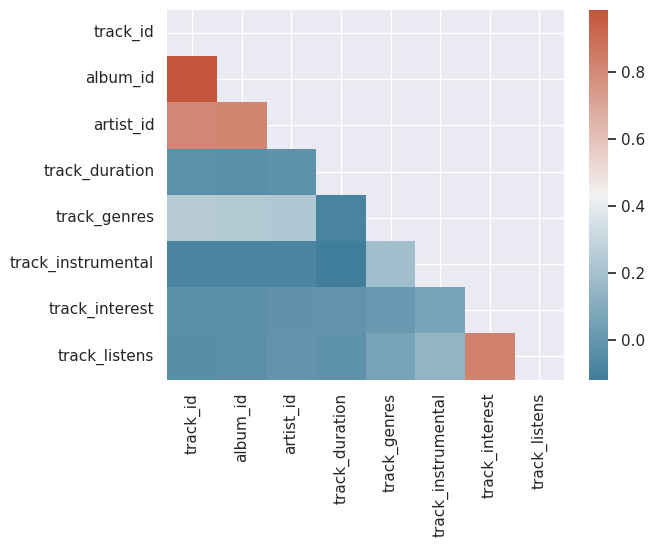

In [195]:
import seaborn as sns

def display_corr(df):
  corr = df.corr()
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  mask = np.triu(np.ones_like(corr, dtype=bool))
  sns.heatmap(corr, mask=mask, cmap=cmap)
  
display_corr(filtered_tracks)

Жанр трека очень плохо коррелирует с его длительностью, поэтому исключим
этот признак из рассмотрения

In [196]:
filtered_tracks = filtered_tracks.drop('track_duration', axis=1)

Теперь добавим значения, предпосчитанные с помощью `librosa`

/tmp/ipykernel_20101/1369159907.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (3 levels on the left, 1 on the right)
  merged = features_df.merge(filtered_tracks, how='inner', on='track_id')


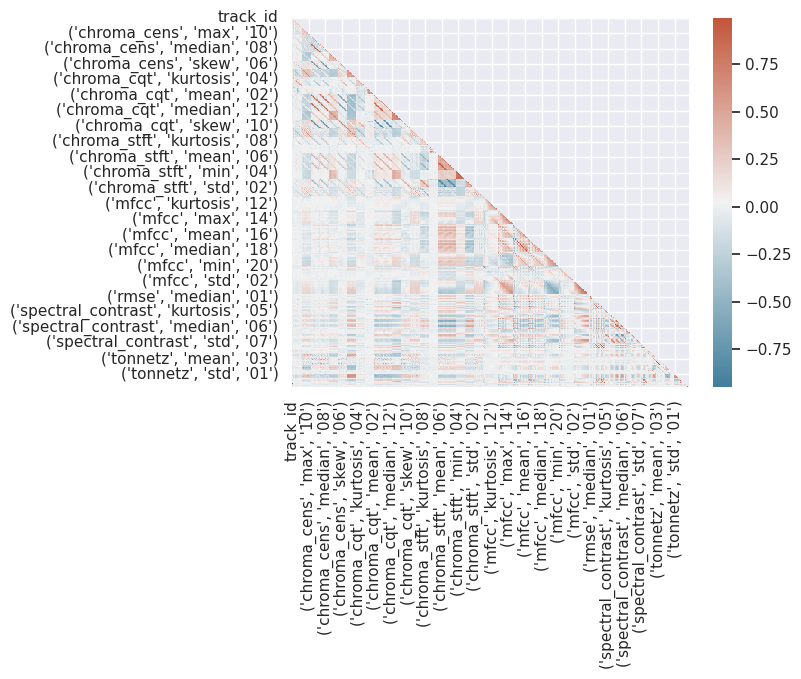

In [197]:
merged = features_df.merge(filtered_tracks, how='inner', on='track_id')

display_corr(merged)

Конечно, признаков слишком много. Из всех возьмем признаки с наибольшей по
модулю корреляцией.

Для этого отсортируем признаки по степени корреляции

In [198]:
correlation = merged.corr()

genres_corr = correlation['track_genres'].sort_values(key=lambda x: np.abs(x), ascending=False)
genres_corr

track_genres                        1.000000
(spectral_bandwidth, median, 01)   -0.340123
(spectral_bandwidth, mean, 01)     -0.335322
(mfcc, mean, 01)                   -0.331284
(spectral_contrast, mean, 07)      -0.328257
                                      ...   
(chroma_cens, kurtosis, 10)         0.001003
(mfcc, skew, 18)                    0.000923
(chroma_cens, skew, 09)             0.000667
(mfcc, median, 09)                  0.000328
(chroma_cens, kurtosis, 03)         0.000273
Name: track_genres, Length: 525, dtype: float64

Изобразим распределение значений корреляции

<Axes: xlabel='track_genres', ylabel='Count'>

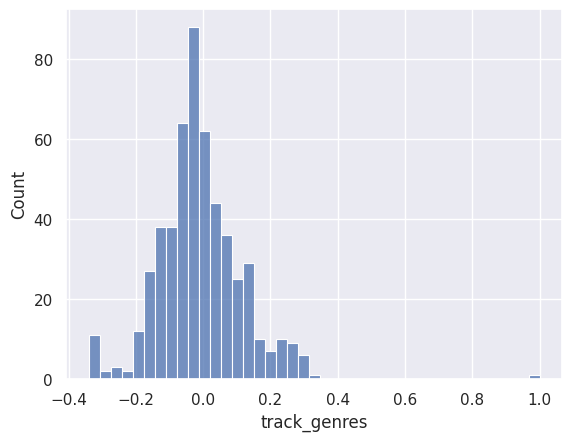

In [199]:
sns.histplot(genres_corr)

Видно, что наибольшее число признаков имеют почти нулевую корреляцию.
В связи с этим выберем наиболее информативные из них

In [200]:
BOUNDARY = 0.2

selected = merged[genres_corr[abs(genres_corr) > BOUNDARY].reset_index()['index']]
selected

,track_genres,"(spectral_bandwidth, median, 01)","(spectral_bandwidth, mean, 01)","(mfcc, mean, 01)","(spectral_contrast, mean, 07)","(mfcc, median, 01)","(spectral_rolloff, skew, 01)","(spectral_rolloff, mean, 01)","(spectral_contrast, median, 07)","(spectral_centroid, mean, 01)",...,"(mfcc, min, 03)","(mfcc, min, 07)","(mfcc, max, 02)","(spectral_contrast, mean, 02)","(spectral_contrast, median, 02)","(mfcc, max, 08)","(zcr, mean, 01)","(mfcc, median, 06)","(rmse, mean, 01)","(mfcc, mean, 06)"
0,21,1618.850098,1607.474365,-163.772964,38.268646,-143.594299,0.347372,3267.804688,39.830345,1639.583252,...,-115.315613,-61.748718,215.541351,15.363138,15.031244,58.169933,0.085629,1.918167e+01,3.188761,18.879372
1,21,1591.517822,1512.917358,-205.440491,36.413609,-181.015961,0.266975,2773.931885,39.101978,1292.958130,...,-87.205124,-59.320251,218.972977,15.969444,15.864572,57.987415,0.053114,1.744389e+01,3.251386,16.942802
2,10,1301.808350,1420.259644,-135.864822,34.886196,-113.085472,1.800220,2603.491943,36.594524,1360.028687,...,-130.033524,-44.849060,235.198517,14.281867,13.763663,42.955067,0.077515,1.509271e+01,3.893810,13.934344
3,17,1479.633423,1475.625366,-225.713318,36.932270,-200.058487,0.655808,2583.014160,37.852184,1232.633789,...,-91.350792,-68.356682,218.817322,16.298210,16.077038,51.864899,0.052379,2.891986e+01,2.953848,28.328743
4,17,1155.707153,1192.835571,-253.143906,29.015615,-259.161804,1.430542,1905.394531,31.146515,941.244141,...,-88.630844,-58.395340,232.621674,18.583612,18.652512,50.200264,0.040267,1.394890e+01,2.576761,11.692952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,21,1055.239868,1094.472168,-288.879303,23.427576,-296.399994,2.989810,1568.987427,21.365528,867.595581,...,-178.103043,-31.414083,283.707458,16.733612,16.522869,38.486408,0.042997,4.427559e+00,2.174565,4.368904
7996,21,1557.110596,1629.846924,-367.696625,27.359835,-388.301178,0.994214,2929.730225,23.360811,1640.368896,...,-101.862770,-56.105015,269.592011,19.529175,19.473154,50.166153,0.082979,-4.085621e-14,1.548146,1.173940
7997,10,1280.634155,1406.540161,-229.868378,32.424583,-224.460236,1.316305,2049.317871,32.489326,969.229065,...,-80.218735,-56.207314,238.620834,17.922699,17.824253,66.826797,0.024532,2.321933e+01,4.202268,22.758905
7998,10,1267.439209,1301.971924,-225.491821,32.980774,-207.745255,1.617722,2065.772705,33.107887,1041.238892,...,-77.324760,-64.465553,248.956421,18.074675,17.745100,42.858521,0.046116,1.091294e+01,2.938613,10.030898


Перекодируем метки классов

In [201]:
from sklearn.preprocessing import LabelEncoder


genre_le = LabelEncoder()

selected.track_genres = genre_le.fit_transform(selected.track_genres)
selected

/tmp/ipykernel_20101/3834816972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected.track_genres = genre_le.fit_transform(selected.track_genres)


,track_genres,"(spectral_bandwidth, median, 01)","(spectral_bandwidth, mean, 01)","(mfcc, mean, 01)","(spectral_contrast, mean, 07)","(mfcc, median, 01)","(spectral_rolloff, skew, 01)","(spectral_rolloff, mean, 01)","(spectral_contrast, median, 07)","(spectral_centroid, mean, 01)",...,"(mfcc, min, 03)","(mfcc, min, 07)","(mfcc, max, 02)","(spectral_contrast, mean, 02)","(spectral_contrast, median, 02)","(mfcc, max, 08)","(zcr, mean, 01)","(mfcc, median, 06)","(rmse, mean, 01)","(mfcc, mean, 06)"
0,5,1618.850098,1607.474365,-163.772964,38.268646,-143.594299,0.347372,3267.804688,39.830345,1639.583252,...,-115.315613,-61.748718,215.541351,15.363138,15.031244,58.169933,0.085629,1.918167e+01,3.188761,18.879372
1,5,1591.517822,1512.917358,-205.440491,36.413609,-181.015961,0.266975,2773.931885,39.101978,1292.958130,...,-87.205124,-59.320251,218.972977,15.969444,15.864572,57.987415,0.053114,1.744389e+01,3.251386,16.942802
2,1,1301.808350,1420.259644,-135.864822,34.886196,-113.085472,1.800220,2603.491943,36.594524,1360.028687,...,-130.033524,-44.849060,235.198517,14.281867,13.763663,42.955067,0.077515,1.509271e+01,3.893810,13.934344
3,4,1479.633423,1475.625366,-225.713318,36.932270,-200.058487,0.655808,2583.014160,37.852184,1232.633789,...,-91.350792,-68.356682,218.817322,16.298210,16.077038,51.864899,0.052379,2.891986e+01,2.953848,28.328743
4,4,1155.707153,1192.835571,-253.143906,29.015615,-259.161804,1.430542,1905.394531,31.146515,941.244141,...,-88.630844,-58.395340,232.621674,18.583612,18.652512,50.200264,0.040267,1.394890e+01,2.576761,11.692952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5,1055.239868,1094.472168,-288.879303,23.427576,-296.399994,2.989810,1568.987427,21.365528,867.595581,...,-178.103043,-31.414083,283.707458,16.733612,16.522869,38.486408,0.042997,4.427559e+00,2.174565,4.368904
7996,5,1557.110596,1629.846924,-367.696625,27.359835,-388.301178,0.994214,2929.730225,23.360811,1640.368896,...,-101.862770,-56.105015,269.592011,19.529175,19.473154,50.166153,0.082979,-4.085621e-14,1.548146,1.173940
7997,1,1280.634155,1406.540161,-229.868378,32.424583,-224.460236,1.316305,2049.317871,32.489326,969.229065,...,-80.218735,-56.207314,238.620834,17.922699,17.824253,66.826797,0.024532,2.321933e+01,4.202268,22.758905
7998,1,1267.439209,1301.971924,-225.491821,32.980774,-207.745255,1.617722,2065.772705,33.107887,1041.238892,...,-77.324760,-64.465553,248.956421,18.074675,17.745100,42.858521,0.046116,1.091294e+01,2.938613,10.030898


In [202]:
selected.columns = selected.columns.map(str)

In [203]:
from sklearn.preprocessing import StandardScaler

for column in selected.columns:
  if column == 'track_genres':
    continue
  selected[column] = StandardScaler().fit_transform(selected[column].to_numpy().reshape(-1, 1))

/tmp/ipykernel_20101/3919542075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected[column] = StandardScaler().fit_transform(selected[column].to_numpy().reshape(-1, 1))
/tmp/ipykernel_20101/3919542075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected[column] = StandardScaler().fit_transform(selected[column].to_numpy().reshape(-1, 1))
/tmp/ipykernel_20101/3919542075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

Убедимся, что `StandardScaler` отработал корректно

In [204]:
selected.describe()

,track_genres,"('spectral_bandwidth', 'median', '01')","('spectral_bandwidth', 'mean', '01')","('mfcc', 'mean', '01')","('spectral_contrast', 'mean', '07')","('mfcc', 'median', '01')","('spectral_rolloff', 'skew', '01')","('spectral_rolloff', 'mean', '01')","('spectral_contrast', 'median', '07')","('spectral_centroid', 'mean', '01')",...,"('mfcc', 'min', '03')","('mfcc', 'min', '07')","('mfcc', 'max', '02')","('spectral_contrast', 'mean', '02')","('spectral_contrast', 'median', '02')","('mfcc', 'max', '08')","('zcr', 'mean', '01')","('mfcc', 'median', '06')","('rmse', 'mean', '01')","('mfcc', 'mean', '06')"
count,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,...,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,3.500000,9.947598e-17,-4.121148e-16,-1.776357e-17,-7.620571e-16,2.273737e-16,-4.618528e-17,5.684342e-17,-1.385558e-16,-1.776357e-16,...,2.557954e-16,-8.526513e-17,4.085621e-16,-3.765876e-16,7.815970e-17,-1.829648e-16,-2.131628e-17,-7.993606e-18,-1.705303e-16,-6.217249e-17
std,2.291431,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,...,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00,1.000063e+00
min,0.000000,-2.442374e+00,-2.673315e+00,-8.341819e+00,-2.903445e+00,-7.970248e+00,-1.095442e+01,-1.980537e+00,-2.623073e+00,-2.061223e+00,...,-4.395684e+00,-6.406196e+00,-8.931983e+00,-3.082066e+00,-2.964208e+00,-3.479518e+00,-1.663026e+00,-5.088162e+00,-1.838379e+00,-4.796596e+00
25%,1.750000,-6.848331e-01,-6.826705e-01,-5.952494e-01,-5.822439e-01,-6.038649e-01,-5.645684e-01,-7.223995e-01,-5.836193e-01,-7.093624e-01,...,-6.306006e-01,-6.043270e-01,-5.412937e-01,-6.975963e-01,-7.054032e-01,-6.282162e-01,-6.475547e-01,-5.655788e-01,-7.376613e-01,-5.608036e-01
50%,3.500000,-4.791684e-02,-2.349495e-02,1.184766e-01,1.505646e-01,1.216726e-01,-2.553486e-01,-9.868034e-02,1.403841e-01,-9.912966e-02,...,3.934132e-03,6.468481e-02,6.373809e-02,-1.353631e-01,-1.492955e-01,-1.992645e-02,-1.668971e-01,8.614418e-02,-1.134209e-01,8.966895e-02
75%,5.250000,6.407927e-01,6.335604e-01,7.017516e-01,7.195905e-01,6.996039e-01,2.681449e-01,6.014415e-01,7.334416e-01,5.692747e-01,...,6.127545e-01,6.702968e-01,6.547827e-01,5.682169e-01,5.683090e-01,6.146821e-01,4.183036e-01,6.768387e-01,5.811625e-01,6.707833e-01
max,7.000000,6.405663e+00,5.372243e+00,3.632791e+00,2.674021e+00,3.421958e+00,1.856961e+01,6.318841e+00,2.787234e+00,8.771461e+00,...,3.442668e+00,3.195089e+00,3.130199e+00,7.374279e+00,7.554612e+00,9.095344e+00,2.032211e+01,3.972493e+00,6.857885e+00,4.062191e+00


## KNN

In [205]:
from sklearn.model_selection import train_test_split


X = selected.drop('track_genres', axis=1)
y = selected['track_genres']

d2_y = np.zeros([y.shape[0], 8])
for i in range(0, len(d2_y)):
    d2_y[i][y[i] - 1] = 1

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=69)

d2_y_train = np.zeros([y_train.shape[0], 8])
for i in range(0, len(d2_y_train)):
    d2_y_train[i][y[i] - 1] = 1

d2_y_test = np.zeros([y_test.shape[0], 8])
for i in range(0, len(d2_y_test)):
    d2_y_test[i][y[i] - 1] = 1

In [206]:
print(y_train)

7316    4
7012    7
1640    0
3153    5
7200    0
       ..
1626    6
2667    7
4041    1
7371    3
7222    2
Name: track_genres, Length: 5360, dtype: int64


In [207]:
def plot_score(n, scores, names):
    d = {names: n, 'score': scores}
    df = pd.DataFrame(d)

    sns.set(style='darkgrid')
    sns.lineplot(x=names, y='score', data=df)

100%|██████████| 99/99 [00:51<00:00,  1.91it/s]


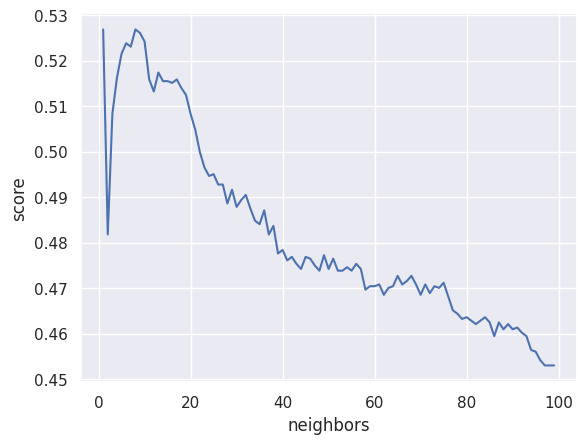

In [208]:
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm


ns = list(map(int, range(1, 100, 1)))
scores = []
for n in tqdm(ns):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    knn.fit(X_train, y_train)
    Y_pred = knn.predict(X_test)
    scores.append(knn.score(X_test, y_test))

plot_score(ns, scores, 'neighbors')

In [209]:
from sklearn.model_selection import cross_val_score


scores = []

for n in tqdm(ns):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    scores.append(cross_val_score(knn, X, y, cv=5).mean())

plot_score(ns, scores, 'neighbors')

 62%|██████▏   | 61/99 [01:15<00:40,  1.07s/it]

100%|██████████| 99/99 [00:31<00:00,  3.11it/s]


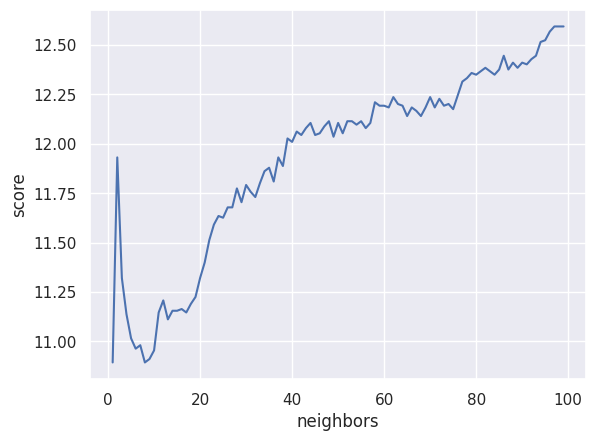

In [ ]:
from sklearn.metrics import log_loss


scores = []
for n in tqdm(ns):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    knn.fit(X_train, y_train)
    d2_pred = knn.predict_proba(X_test)
    max_ind = np.argmax(d2_pred, axis=1)
    d2_pred.fill(0)
    for ind in range(0, len(max_ind)):
        d2_pred[ind][max_ind[ind]] = 1
    logl = log_loss(y_test, d2_pred, eps= 1e-10)
    # print(logl)
    scores.append(logl)

plot_score(ns, scores, 'neighbors')

In [ ]:
y.shape

(8000,)

In [ ]:
scores = []
for n in tqdm(ns):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    knn.fit(X_train, d2_y_train)
    scores.append(knn.score(X_test, y_test))

plot_score(ns, scores, 'neighbors')

  0%|          | 0/99 [00:00<?, ?it/s]


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- index


In [ ]:
print(y_test.reset)

AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
d2_y.shape

(8000, 8)

In [ ]:
X.shape

(8000, 47)

In [ ]:
scores = []
for n in tqdm(ns):
    knn = KNeighborsClassifier(p=1, n_neighbors=n)
    cvs = cross_val_score(knn, X, y, cv=5, scoring="neg_log_loss")
    scores.append(cvs.mean()) 
    
plot_score(ns, scores, 'neighbors')

 72%|███████▏  | 71/99 [00:54<00:21,  1.30it/s]


KeyboardInterrupt: 

In [ ]:
y.shape

(8000,)

## SVC

### C-svc

#### форма функции решения: one vs one

100%|██████████| 9/9 [00:43<00:00,  4.88s/it]


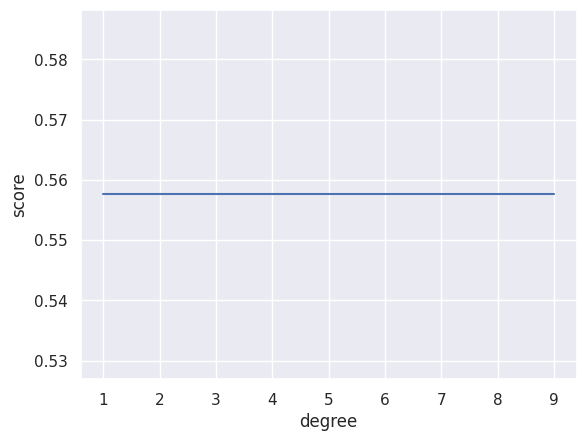

In [ ]:
from sklearn import svm

scores = []
ps = list(map(int, range(1, 10, 1)))
for p in tqdm(ps):
    svc = svm.SVC(degree=p, decision_function_shape='ovo')
    svc.fit(X_train, y_train)
    Y_pred = svc.predict(X_test)
    scores.append(svc.score(X_test, y_test))

plot_score(ps, scores, 'degree')

100%|██████████| 99/99 [06:06<00:00,  3.70s/it]


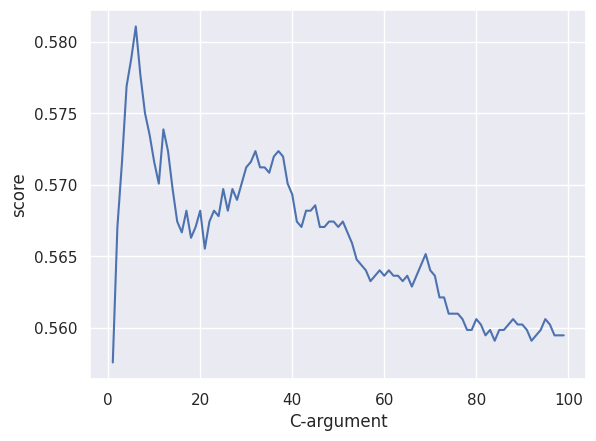

In [ ]:

scores = []
Cs = list(map(int, range(1, 100, 1)))

for c in tqdm(Cs):
    svc = svm.SVC(C=c, decision_function_shape='ovo')
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test, y_test))

plot_score(Cs, scores, 'C-argument')

100%|██████████| 99/99 [29:54<00:00, 18.13s/it]


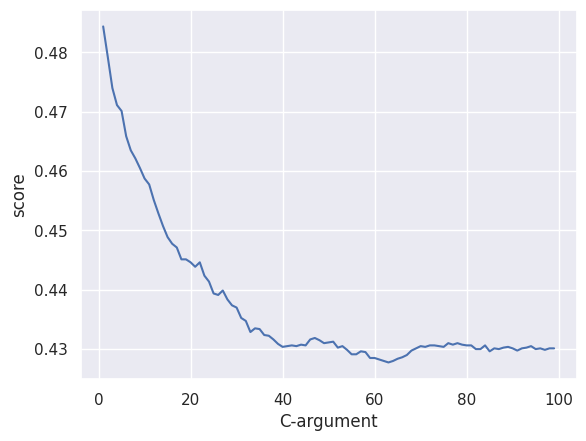

In [ ]:
scores =[]

for c in tqdm(Cs):
    svc = svm.SVC(C=c, decision_function_shape='ovo')
    cvs = cross_val_score(svc, X, y, cv=5)
    scores.append(cvs.mean())

plot_score(Cs, scores, 'C-argument')

100%|██████████| 99/99 [13:18<00:00,  8.06s/it]


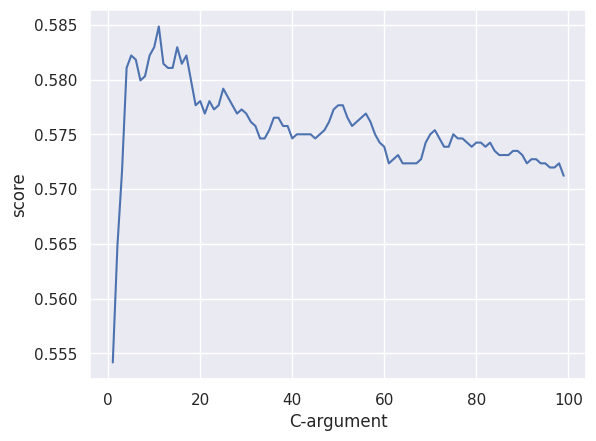

In [ ]:
from sklearn.multiclass import OneVsOneClassifier


scores = []
Cs = list(map(int, range(1, 100, 1)))

for c in tqdm(Cs):
    clf = OneVsOneClassifier(svm.SVC(C=c))
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plot_score(Cs, scores, 'C-argument')

100%|██████████| 99/99 [1:10:56<00:00, 43.00s/it] 


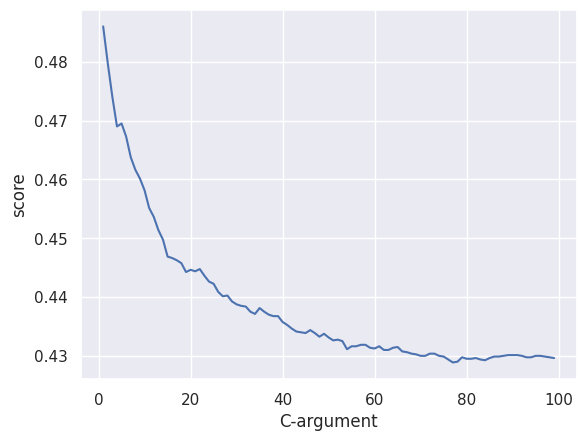

In [ ]:
scores = []

for c in tqdm(Cs):
    clf = OneVsOneClassifier(svm.SVC(C=c))
    cvs = cross_val_score(clf, X, y, cv=5)
    scores.append(cvs.mean())
plot_score(Cs, scores, 'C-argument')

#### форма функции решения: one vs rest

100%|██████████| 99/99 [05:09<00:00,  3.12s/it]


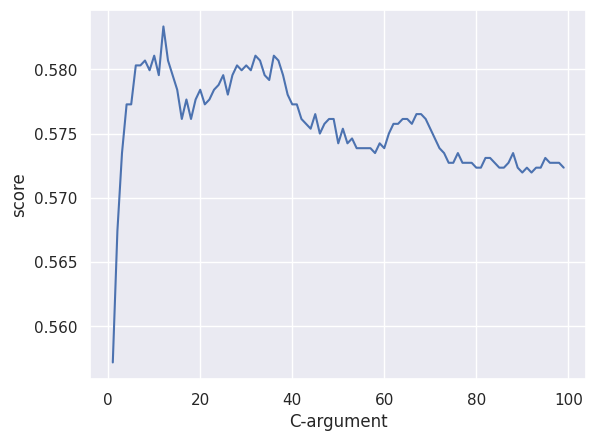

In [ ]:
scores = []

for c in tqdm(Cs):
    svc = svm.SVC(C=c, break_ties=True)
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test, y_test))

plot_score(Cs, scores, 'C-argument')

100%|██████████| 99/99 [15:31<00:00,  9.41s/it]


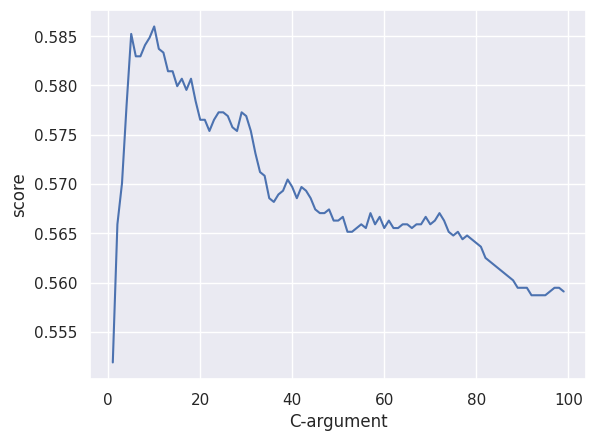

In [ ]:
from sklearn.multiclass import OneVsRestClassifier


scores = []

for c in tqdm(Cs):
    clf = OneVsRestClassifier(svm.SVC(C=c))
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plot_score(Cs, scores, 'C-argument')

100%|██████████| 49/49 [52:50<00:00, 64.70s/it]


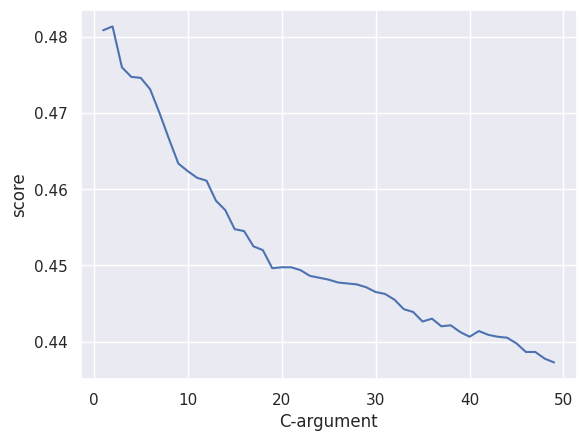

In [ ]:
scores = []
Cs = list(map(int, range(1, 50, 1)))
for c in tqdm(Cs):
    clf = OneVsRestClassifier(svm.SVC(C=c))
    cvs = cross_val_score(clf, X, y, cv=5)
    scores.append(cvs.mean())

plot_score(Cs, scores, 'C-argument')

### $\nu$-svc

100%|██████████| 49/49 [02:14<00:00,  2.75s/it]


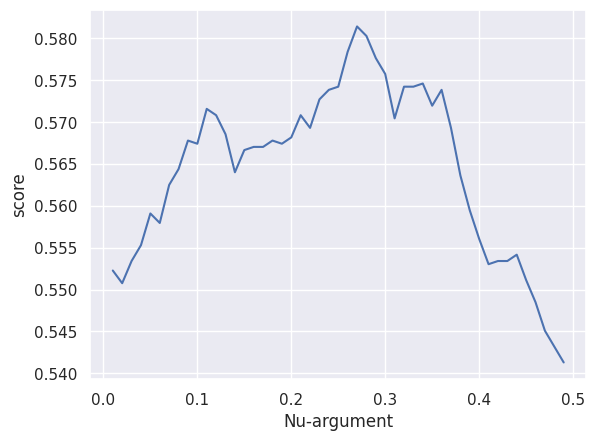

In [ ]:
scores = []
Nus = np.arange(0.01, 0.5, 0.01)
for nu in tqdm(Nus):
    nu_svc = svm.NuSVC(nu=nu, decision_function_shape='ovo')
    nu_svc.fit(X_train, y_train)
    scores.append(nu_svc.score(X_test, y_test))

plot_score(Nus, scores, 'Nu-argument')

## NN

In [ ]:
selected.shape

(8000, 48)

In [ ]:
from tensorflow import keras

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(47))
model.add(tf.keras.layers.Dense(47, activation='relu'))
# model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
# model.add(tf.keras.layers.Dropout(.2, input_shape=(2,)))
model.add(tf.keras.layers.Dense(8, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 47)                2256      
                                                                 
 dense_33 (Dense)            (None, 128)               6144      
                                                                 
 dense_34 (Dense)            (None, 128)               16512     
                                                                 
 dense_35 (Dense)            (None, 8)                 1032      
                                                                 
Total params: 25,944
Trainable params: 25,944
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train.shape
print(X_train.shape, y_train.shape)

(5360, 47) (5360,)


In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/danil/.cache/pypoetry/virtualenvs/gcr-TWFdq8Y_-py3.10/lib/python3.10/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 8) are incompatible
